__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# !pip install plotly ipywidgets plotly-geo

In [2]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import plotly
# import contextily as ctx
# from shapely.geometry import Polygon

/opt/venv/jupyter_0/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()
# pd.options.plotting.backend = 'plotly'

In [4]:
# !ls -1 data

In [5]:
# import shapely
# shapely.__version__
# '1.8.4'

In [6]:
# !pip install greppo==0.0.32
# !pip install shapely==1.8.2

In [7]:
# !pip install --upgrade pip

In [8]:
# !pip install --upgrade pygeos==0.10.2

In [9]:
# !pip freeze > requirements.txt
# !pip install -r requirements.txt

## считываем данные

In [10]:
data_file = 'data/data_flat.pkl'

In [11]:
cols = ['title','adr','latitude','longitude','priceM','dt']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

43394


,title,adr,latitude,longitude,priceM,dt
29065,"1-комн. апарт., 29,9 м², 3/5 этаж","Севастополь, район Гагаринский, проезд Рубежный, 28",44.58,33.41,5.00,2022-09-16
28295,"1-комн. кв., 30,9 м², 2/5 этаж","Севастополь, район Нахимовский, Радиогорка, улица Михайловская, 15",44.631834,33.529537,4.25,2022-09-15
31188,"1-комн. апарт., 14,5 м², 1/4 этаж","Севастополь, район Нахимовский, село Орловка, шоссе Качинское, 35/9",44.731916,33.547432,2.75,2022-09-19


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43394 entries, 0 to 43393
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          43394 non-null  object        
 1   price          43394 non-null  int64         
 2   adr_orig       43394 non-null  object        
 3   description    43394 non-null  object        
 4   obj_name       43394 non-null  object        
 5   ts             43394 non-null  datetime64[ns]
 6   avito_page     22639 non-null  float64       
 7   place          43394 non-null  object        
 8   nrooms         43394 non-null  int64         
 9   floor          43394 non-null  int64         
 10  nfloors        43394 non-null  int64         
 11  area           43394 non-null  float64       
 12  is_studio      43394 non-null  bool          
 13  is_apartment   43394 non-null  bool          
 14  is_part        43394 non-null  bool          
 15  is_auction     4339

In [13]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

43394
43394


### ограничиваем тип объекта 

In [14]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
print(len(df))

43394
37490
37489


In [15]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
19718,"1-к. квартира, 53 м², 7/10 эт.","Севастополь, улица Генерала Крейзера, д. 8, корп. 5",44.605573,33.511921,8.47
17044,"1-к. квартира, 26 м², 1/3 эт.","Севастополь,аллея Защитников 35-й Батареи, д. 11а",44.556593,33.412478,3.67
32743,"2-комн. кв., 48 м², 1/5 этаж","Севастополь, район Гагаринский, Стрелецкая бухта, улица Дмитрия Ульянова, 11",44.604591,33.49417,5.99


In [16]:
df.sample(10)[['title','adr','url']].to_dict('records') 

[{'title': '2-комн. кв., 37,2 м², 1/1 этаж',
  'adr': 'Севастополь, район Ленинский, улица Мокроусова, 6',
  'url': 'https://sevastopol.cian.ru/sale/flat/257765689/'},
 {'title': '1-к. квартира, 50,3\xa0м², 8/8\xa0эт.',
  'adr': 'Севастополь, улица Павла Корчагина, стр. 7',
  'url': 'https://avito.ru/2582397255'},
 {'title': '3-к. квартира, 70\xa0м², 1/5\xa0эт.',
  'adr': 'Севастополь, улица Генерала Лебедя, 18',
  'url': 'https://avito.ru/2478051280'},
 {'title': '1-к. квартира, 59\xa0м², 3/3\xa0эт.',
  'adr': 'Севастополь,аллея Защитников 35-й Батареи, д. 11а',
  'url': 'https://avito.ru/2372604864'},
 {'title': '2-комн. кв., 61 м², 6/10 этаж',
  'adr': 'Севастополь, район Гагаринский, шоссе Камышовое, 37Бк2',
  'url': 'https://sevastopol.cian.ru/sale/flat/277408746/'},
 {'title': '1-к. квартира, 40,3\xa0м², 8/8\xa0эт.',
  'adr': 'Севастополь, улица Павла Корчагина, стр. 2',
  'url': 'https://avito.ru/2218259817'},
 {'title': '2-к. квартира, 59,1\xa0м², 9/9\xa0эт.',
  'adr': 'Севасто

In [17]:
del df

In [18]:
gdf[['title','adr','priceM','geometry']].sample(100).explore()

## общая статистика

### количество предложений

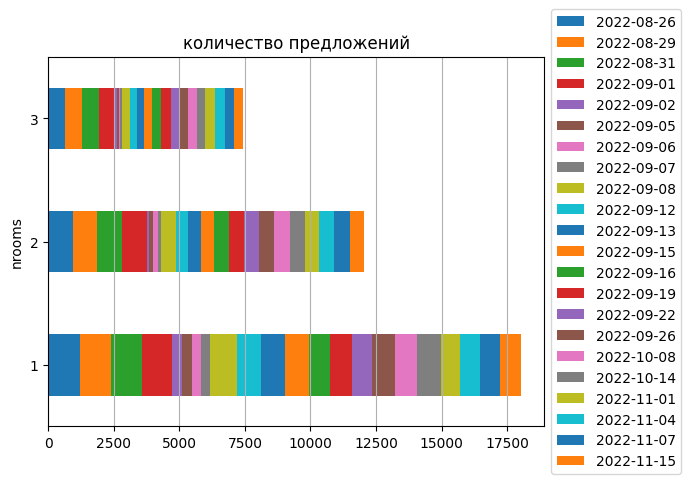

In [19]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

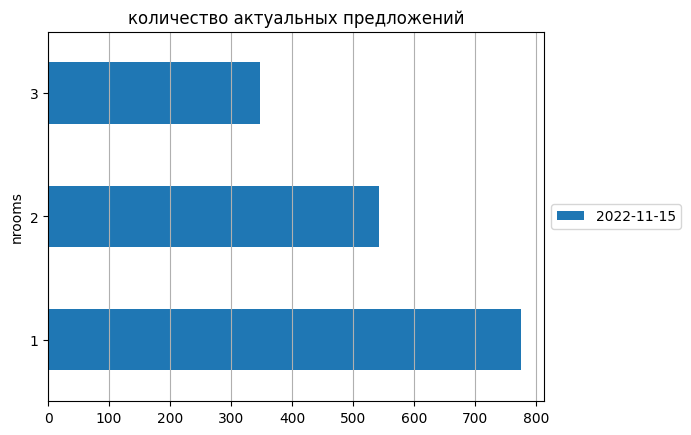

In [20]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений', stacked=True )
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [21]:
stat = gdf.groupby(['nrooms','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
# stat

count  mean  std  min   1%  10%  25%   50%   75%   90%  \
nrooms dt                                                                    
1      2022-08-26 1203.00  6.26 1.91 1.59 2.31 4.07 5.00  6.00  7.30  8.50   
       2022-08-29 1191.00  6.25 1.90 1.75 2.73 4.11 5.00  6.00  7.21  8.50   
       2022-08-31 1180.00  6.34 1.92 1.30 2.72 4.20 5.09  6.00  7.43  8.76   
       2022-09-01 1159.00  6.32 1.89 1.30 2.78 4.15 5.10  6.00  7.40  8.51   
       2022-09-02  365.00  6.31 2.10 3.65 3.65 4.00 4.85  5.81  7.21  9.35   
...                   ...   ...  ...  ...  ...  ...  ...   ...   ...   ...   
3      2022-10-14  314.00 11.02 7.73 5.00 5.54 7.00 8.00  9.05 10.80 15.00   
       2022-11-01  385.00 11.29 5.04 4.90 5.75 7.10 8.30 10.21 12.50 16.50   
       2022-11-04  370.00 11.24 4.85 4.90 5.71 7.19 8.43 10.21 12.22 16.32   
       2022-11-07  364.00 11.55 5.19 4.60 5.80 7.27 8.49 10.33 12.75 17.00   
       2022-11-15  348.00 11.56 5.33 4.70 5.50 7.29 8.50 10.33 12.50 17.03   

                     max  
nrooms dt                 
1      2022-08-26  18.50  
       2022-08-29  18.50  
       2022-08-31  18.50  
       2022-09-01  18.50  
       2022-09-02  14.90  
...                  ...  
3      2022-10-14 100.00  
       2022-11-01  45.00  
       2022-11-04  45.00  
       2022-11-07  45.00  
       2022-11-15  45.00  

[66 rows x 11 columns]

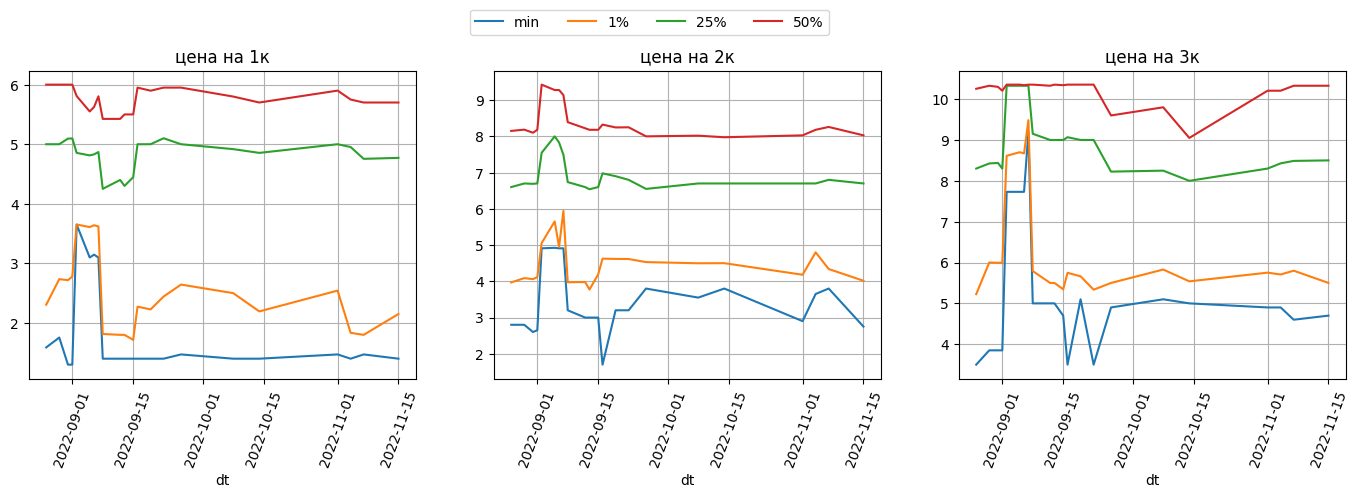

In [22]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и медиана актуальной цены

In [23]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()


In [24]:
# frame_all.to_file('data/frame_all.geojson', driver='GeoJSON')

In [25]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [26]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0],cell_size=6 )
print(len(grid))
grid.sample(2)

24


,hex_id,geometry
17,862d2894fffffff,"POLYGON ((33.56208 44.65198, 33.54065 44.62256, 33.56756 44.59377, 33.61589 44.59440, 33.63733 44.62382, 33.61044 44.65261, 33.56208 44.65198))"
10,862d2d487ffffff,"POLYGON ((33.62646 44.74017, 33.60499 44.71079, 33.63190 44.68201, 33.68026 44.68260, 33.70175 44.71197, 33.67486 44.74076, 33.62646 44.74017))"


In [27]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [28]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [29]:
frames.explore('area_name', legend=True)

In [30]:
# frames.to_file('data/frames.geojson', driver='GeoJSON')

In [31]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
# 'Севастополь, Малахов курган',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

37489
3186


In [32]:
frames.iloc[[0]]

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"


In [33]:
# новые (актуальные) предложения
# gdf_[gdf_['ts']>ts][['title','priceM','adr','geometry']].explore( legend=False)
gdf_[['title','priceM','adr','geometry']].explore( legend=False)

### количество предложений

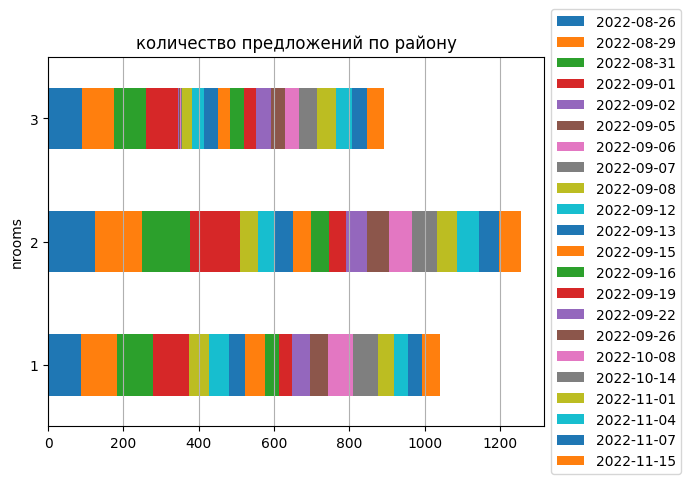

In [34]:
fig = ( # количество предложений
    gdf_.groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений по району',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

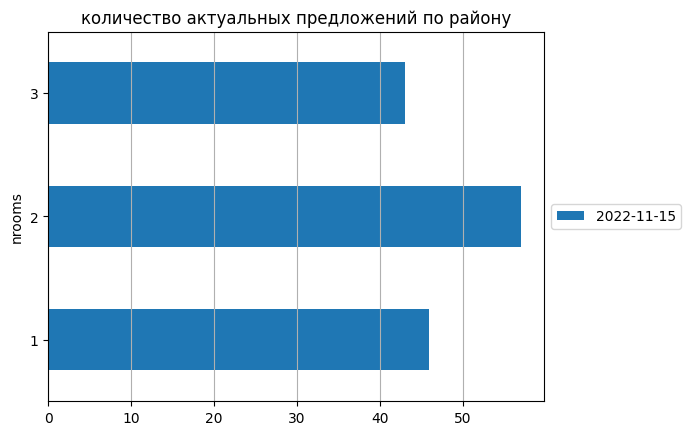

In [35]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений по району', stacked=True )
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [36]:
stat = gdf_.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
# stat

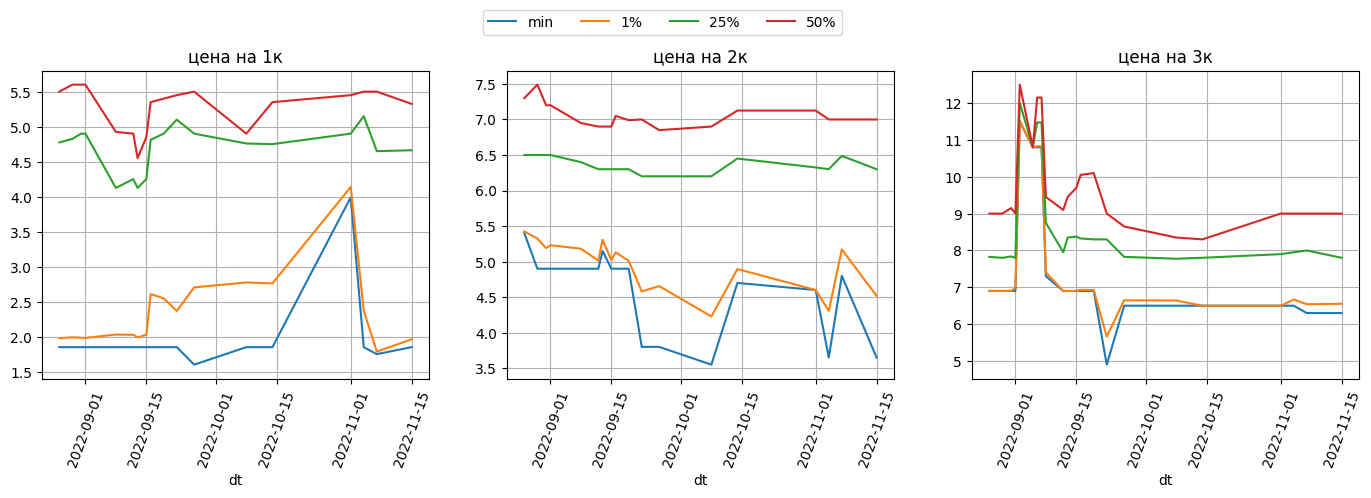

In [37]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и  медиана актуальной цены

In [38]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
39,892d289404bffff,"POLYGON ((33.51969 44.58301, 33.51937 44.58122, 33.52145 44.58006, 33.52386 44.58068, 33.52419 44.58247, 33.52210 44.58363, 33.51969 44.58301))"
1,892d289429bffff,"POLYGON ((33.51598 44.57522, 33.51566 44.57343, 33.51774 44.57227, 33.52015 44.57290, 33.52048 44.57469, 33.51839 44.57585, 33.51598 44.57522))"


In [39]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)